In [24]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.vision.core import *
from fastai.vision.data import *
from fastai.data.all import *

from pathlib import Path

import pdb

import numpy as np
import matplotlib.pyplot as plt

## Checking the data

In [25]:
path = Path('./Data')

images_path = path/'images'
labels_path = path/'labels'

print(f'Checking number of files - images: {len([f for f in images_path.iterdir()])})\
      masks:{len([f for f in labels_path.iterdir()])}')
        
# Checking file shapes
idx = 22
img_path = [f for f in images_path.iterdir()][idx]
msk_path = [f for f in labels_path.iterdir()][idx]
      
img = np.load(str(img_path))
msk = np.load(str(msk_path))
      
print(f'Checking shapes - image: {img.shape} mask: {msk.shape}')

Checking number of files - images: 40)      masks:40
Checking shapes - image: (13, 366, 366) mask: (366, 366)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


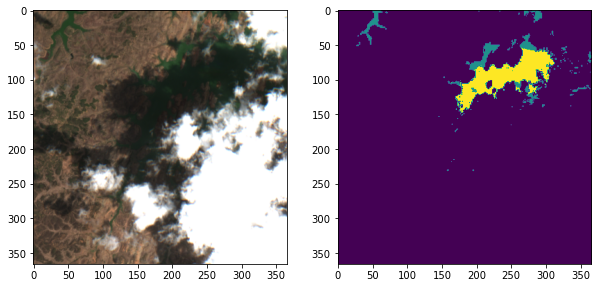

In [26]:
# Plotting a sample
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img.transpose((1, 2, 0))[..., [3, 2, 1]]*3.0)
ax[1].imshow(msk)

## TensorImage subclassing

In [27]:
def open_npy(fn, chnls=None, cls=torch.Tensor):
    im = torch.from_numpy(np.load(str(fn))).type(torch.float32)
    if chnls is not None:
        im = im[chnls]
    return cls(im)

class MSTensorImage(TensorImage):
    
    def __init__(self, x, chnls_first=False):
        self.chnls_first = chnls_first
        
    @classmethod
    def create(cls, data:(Path,str,ndarray), chnls=None, chnls_first=True):
        
        if isinstance(data, Path) or isinstance(data, str):
            if str(data).endswith('npy'): 
                im = open_npy(fn=data, chnls=chnls, cls=torch.Tensor)
        
        elif isinstance(data, ndarray):
            im = torch.from_numpy(data)
        else:
            im = data
            
        return cls(im, chnls_first=chnls_first)
    
    
    def show(self, chnls=[3, 2, 1], bright=1., ctx=None):
            
        if img.ndim > 2:
            visu_img = self[..., chnls] if not self.chnls_first else self.permute([1, 2, 0])[..., chnls]
        else:
            visu_img = self
            
        visu_img = visu_img.squeeze()
        
        visu_img *= bright
        visu_img = np.where(visu_img > 1, 1, visu_img)
        visu_img = np.where(visu_img < 0, 0, visu_img)
        
        plt.imshow(visu_img) if ctx is None else ctx.imshow(visu_img)
        
        return ctx
    
    def __repr__(self):
        
        return (f'MSTensorImage: {self.shape}')

MSTensorImage: torch.Size([13, 366, 366])


<AxesSubplot:>

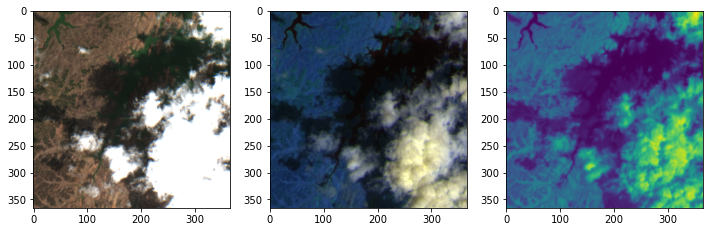

In [28]:
img = MSTensorImage.create(img_path)
print(img)

_, ax = plt.subplots(1, 3, figsize=(12, 4))
img.show(bright=3., ctx=ax[0])
img.show(chnls=[2, 7, 10], ctx=ax[1])
img.show(chnls=[11], ctx=ax[2])

## Define TensorMask class

torch.Size([366, 366])


<AxesSubplot:>

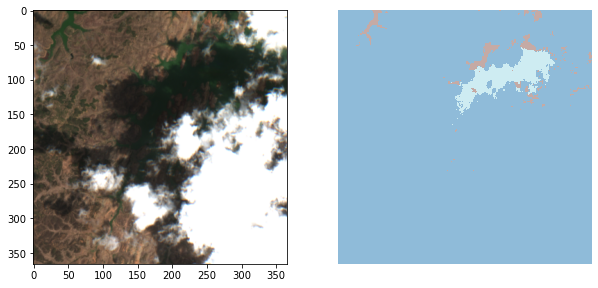

In [29]:
mask = TensorMask(open_npy(msk_path))
print(mask.shape)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
img.show(bright=3., ctx=ax[0])
mask.show(ctx=ax[1])

## Creating the datablock

In [30]:
def get_lbl_fn(img_fn: Path):
    lbl_path = img_fn.parent.parent/'labels'
    lbl_name = img_fn.name
    return (lbl_path/lbl_name)

db = DataBlock(blocks=(TransformBlock(type_tfms=partial(MSTensorImage.create, chnls_first=True)),
                       TransformBlock(type_tfms=[get_lbl_fn, partial(open_npy, cls=TensorMask)],
                                      item_tfms=AddMaskCodes(codes=['clear', 'water', 'shadow'])),
                      ),
               get_items=partial(get_files, extensions='.npy'),
               splitter=RandomSplitter(valid_pct=0.1)
              )

db.summary(source=images_path)
               

Setting-up type transforms pipelines
Found 40 items
2 datasets of sizes 36,4
Setting up Pipeline: partial
Setting up Pipeline: get_lbl_fn -> partial

Building one sample
  Pipeline: partial
    starting from
      Data/images/Oros_1_7.npy
    applying partial gives
      MSTensorImage of size 13x366x366
  Pipeline: get_lbl_fn -> partial
    starting from
      Data/images/Oros_1_7.npy
    applying get_lbl_fn gives
      Data/labels/Oros_1_7.npy
    applying partial gives
      TensorMask of size 366x366

Final sample: (MSTensorImage: torch.Size([13, 366, 366]), TensorMask([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]))


Found 40 items
2 datasets of sizes 36,4
Setting up Pipeline: partial
Setting up Pipeline: get_lbl_fn -> partial
Setting up after_item: Pipeline: AddMaskCodes -> ToTensor
S

## Creating the dataloader

<AxesSubplot:>

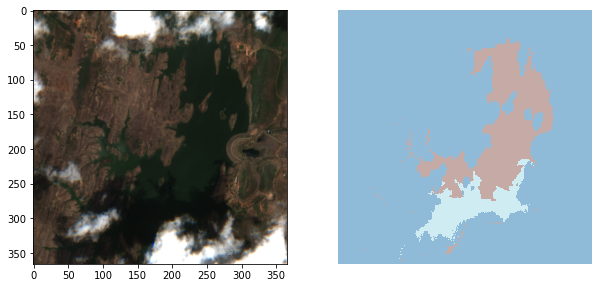

In [31]:
ds = db.datasets(source=images_path)

idx = 1
img = ds.train[idx][0]
msk = ds.train[idx][1]

_, ax = plt.subplots(1, 2, figsize=(10, 5))
img.show(ctx=ax[0], bright=2.)
msk.show(ctx=ax[1])

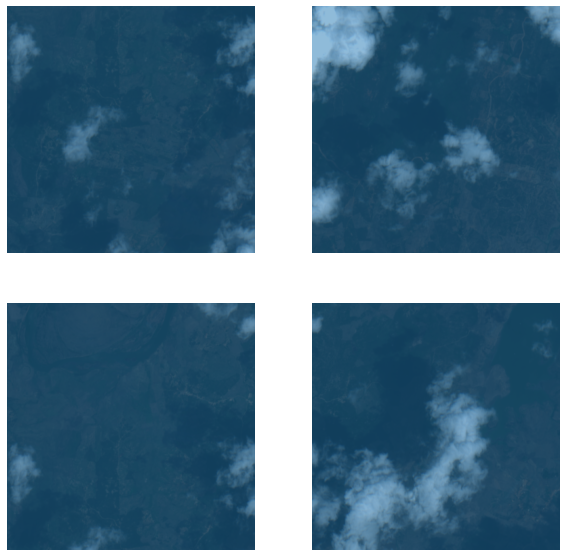

In [32]:
dls = db.dataloaders(source=images_path, bs=4, num_workers=0)

dls.show_batch(figsize=(10, 10))